## Reinforcement Learning - Assignment 1 - Jack Murray

### Setup Steps

#### Load Packages

In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import matplotlib.pyplot as plt

#### Create a class representing the environment

In [2]:
class Segment: #(gym.Env):
    def __init__(self,numActions,startObservation,p,terminal,done):
        self.numActions = numActions
        self.observation = startObservation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.numActions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2*self.terminal+1)
        self.done = done
    def step(self,action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation!=0
        assert self.observation!=(2*self.terminal)
        observation = self.observation
        done = self.done
        if action==0:
            observation_next = observation + np.random.choice([-1,1],p=[self.p,1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1,1],p=[1-self.p,self.p])
        if observation_next == (2*self.terminal):
            done = True
        elif observation_next == 0:
            done = True
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation,observation_next,action)
        return [self.observation,reward,done]
    def rewards(self,observation,observation_next,action):
        if observation_next==(2*self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    def reset(self):
        observation = self.startObservation
        self.observation = observation
        self.done = False
        return observation

### Question 1 -- Always try to go Right

#### Write a policy -- always move to the right

In [3]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [4]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

In [5]:
env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [6]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [7]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,1.0,2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,2.0,3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,3.0,4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,4.0,5.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,5.0,6.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,6.0,7.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,7.0,8.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,8.0,9.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,9.0,10.0,1.0,1.00,0.98,0.833748,0.833748


#### Compute the sum of the discounted rewards realized during the episode

In [8]:
v0 = np.sum(dta['beta^t_reward'])
v0

0.41811716745552446

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [9]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [10]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,-1.0,0.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,0.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,-1.0,0.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,0.0,1.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
16949,999.0,11.0,7.0,8.0,1.0,-0.05,0.98,0.800731,-0.040037
16950,999.0,12.0,8.0,9.0,1.0,-0.05,0.98,0.784717,-0.039236
16951,999.0,13.0,9.0,8.0,1.0,-0.05,0.98,0.769022,-0.038451
16952,999.0,14.0,8.0,9.0,1.0,-0.05,0.98,0.753642,-0.037682


#### Group by episode to sum the discounted realized rewards for each episode

In [11]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,-0.115686
1.0,0.084992
2.0,-0.387873
3.0,-0.300785
4.0,0.302560
...,...
995.0,0.084992
996.0,-0.115686
997.0,0.418117


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [12]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,0.050749
std,0.266606
min,-1.145766
1%,-0.703081
5%,-0.471514
10%,-0.300785
25%,-0.115686
50%,0.084992
75%,0.302560


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

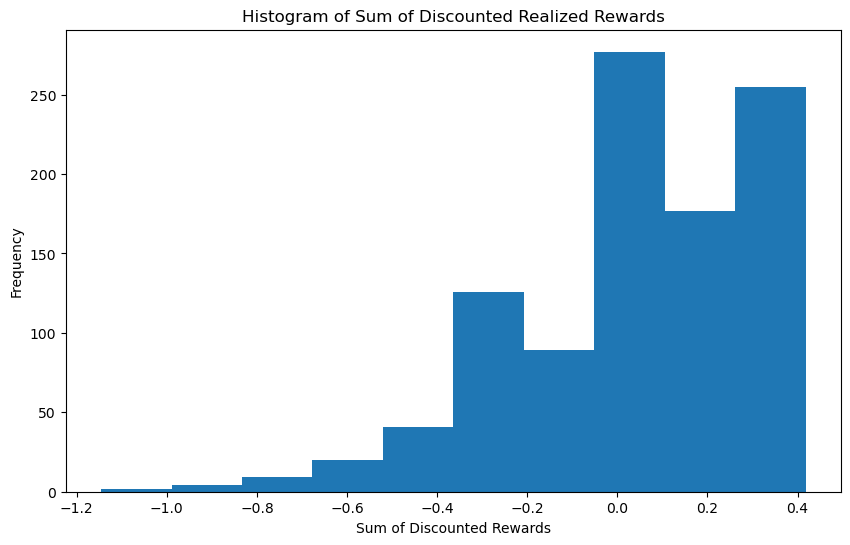

In [13]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [14]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.8,terminal=10,done=False)
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [15]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
1,-9.0,0.0,1.0,-8.0,-7.0,1.0,-0.05,0.98,0.980000,-0.049000
2,-9.0,0.0,2.0,-7.0,-8.0,1.0,-0.05,0.98,0.960400,-0.048020
3,-9.0,0.0,3.0,-8.0,-7.0,1.0,-0.05,0.98,0.941192,-0.047060
4,-9.0,0.0,4.0,-7.0,-6.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...,...
304214,9.0,995.0,2.0,9.0,10.0,1.0,1.00,0.98,0.960400,0.960400
304215,9.0,996.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
304216,9.0,997.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
304217,9.0,998.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [16]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-0.6805,0.3161,-1.5896,-1.5896,-1.0594,-1.0018,-1.0000,-0.6664,-0.4301,-0.2559,-0.1634,-0.0670,-0.0670
-8.0,1000.0,-0.5441,0.2838,-1.5896,-1.2494,-1.0300,-0.9712,-0.7031,-0.4715,-0.3008,-0.2101,-0.1157,-0.0174,-0.0174
-7.0,1000.0,-0.4627,0.2832,-1.5896,-1.1729,-1.0018,-0.8088,-0.6664,-0.4301,-0.2559,-0.0670,-0.0670,0.0333,0.0333
-6.0,1000.0,-0.3852,0.2740,-1.5896,-1.1441,-0.9082,-0.7031,-0.5518,-0.3879,-0.2101,-0.0174,-0.0174,0.0850,0.0850
-5.0,1000.0,-0.3427,0.2943,-1.5896,-1.1181,-0.8757,-0.7390,-0.5121,-0.2559,-0.1393,0.0333,0.0333,0.1377,0.1377
-4.0,1000.0,-0.2668,0.2816,-1.5896,-0.9712,-0.7742,-0.7031,-0.4715,-0.2101,-0.0174,0.0850,0.0850,0.1916,0.1916
-3.0,1000.0,-0.1753,0.2828,-1.5896,-1.0018,-0.6664,-0.5908,-0.3448,-0.1634,0.0333,0.1377,0.2465,0.2465,0.2465
-2.0,1000.0,-0.0881,0.2603,-1.1458,-0.7742,-0.5518,-0.4715,-0.2101,-0.0174,0.0850,0.1916,0.3026,0.3026,0.3026
-1.0,1000.0,-0.0125,0.2593,-0.9400,-0.7390,-0.5121,-0.3448,-0.1634,0.0333,0.1377,0.2465,0.3598,0.3598,0.3598


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

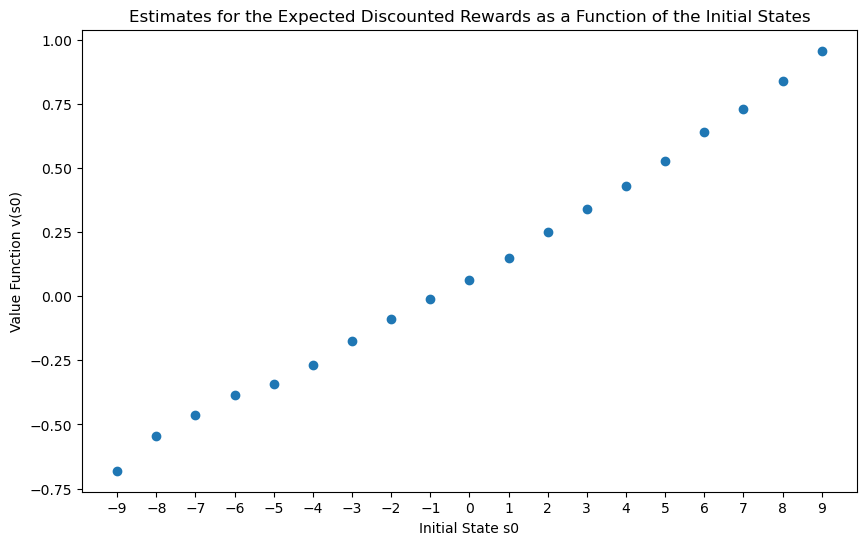

In [18]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either end of the path (-9 or 9), the episode ends and the robot doesn't make any more moves. Therefore, the top left and bottom right corner of the matrix both equal 1, as these represent the robot's current state being the leftmost or rightmost space in the path.

For every other space, the robot has an 80% chance of moving right, and a 20% chance of moving left.

In [19]:
P = np.zeros((19, 19))
P = pd.DataFrame(P)

for s in list(range(19)):
    if s == 0: # if robot is at the leftmost space
        P.iloc[s, s] = 1.0 # robot does not move
    elif s == 18: # if robot is at the rightmost space
        P.iloc[s, s] = 1.0 # robot does not move
    else: # if robot is anywhere else
        P.iloc[s, s+1] = 0.8 # 80% chance of moving right as intended
        P.iloc[s, s-1] = 0.2 # 20% chance of moving left
        
P.columns = list(range(-9, 10))
P.index = list(range(-9, 10))
P

,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9
-9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-5,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Question 2 -- Always try to go Left

#### Write a policy -- always move to the left

Keep the "policy" the same, but change the episode probability below to 0.2, which is effectively the same as saying that the robot will try to go left with a 80% success rate, but will go right 20% of the time.

In [20]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [21]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

In [22]:
env = Segment(numActions=2,startObservation=10,p=0.2,terminal=10,done=False) # change p = 0.2 to account for the updated policy (try to go left with 80% success, go right the other 20%)
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [23]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [24]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,-1.0,-2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,-2.0,-3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,-3.0,-4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,-4.0,-5.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,-5.0,-6.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,-6.0,-5.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,-5.0,-6.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,-6.0,-7.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,-7.0,-6.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [25]:
v0 = np.sum(dta['beta^t_reward'])
v0

-1.3921463460318941

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [26]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.2,terminal=10,done=False) # change p = 0.2
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [27]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,-1.0,-2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,-2.0,-3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,-3.0,-4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,-4.0,-5.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
16739,999.0,5.0,-5.0,-6.0,1.0,-0.05,0.98,0.903921,-0.045196
16740,999.0,6.0,-6.0,-7.0,1.0,-0.05,0.98,0.885842,-0.044292
16741,999.0,7.0,-7.0,-8.0,1.0,-0.05,0.98,0.868126,-0.043406
16742,999.0,8.0,-8.0,-9.0,1.0,-0.05,0.98,0.850763,-0.042538


#### Group by episode to sum the discounted realized rewards for each episode

In [28]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,-1.249378
1.0,-1.594803
2.0,-1.298903
3.0,-1.392146
4.0,-1.392146
...,...
995.0,-1.346466
996.0,-1.249378
997.0,-1.630649


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [29]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,-1.402329
std,0.113134
min,-1.895683
1%,-1.698761
5%,-1.596595
10%,-1.557479
25%,-1.478151
50%,-1.392146
75%,-1.298903


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

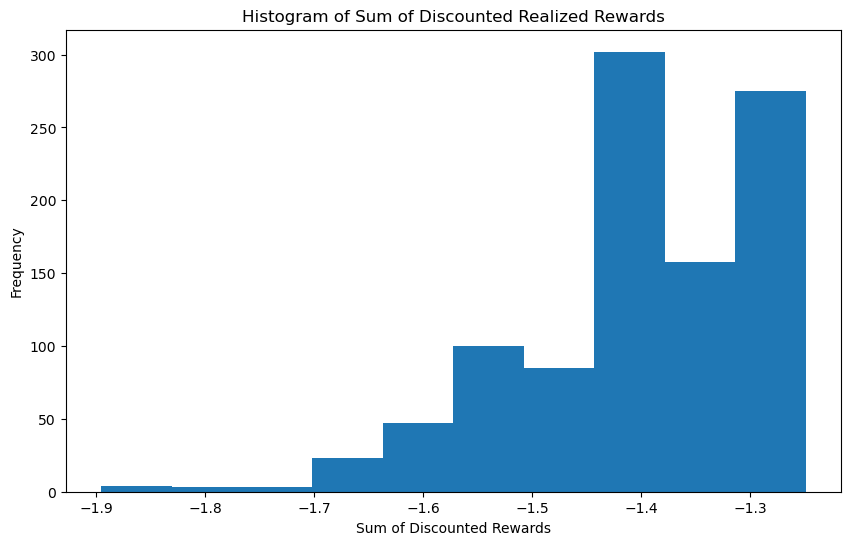

In [30]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [31]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.2,terminal=10,done=False) # change p = 0.2
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [32]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
1,-9.0,1.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
2,-9.0,2.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
3,-9.0,2.0,1.0,-8.0,-9.0,1.0,-0.05,0.98,0.980000,-0.049000
4,-9.0,2.0,2.0,-9.0,-8.0,1.0,-0.05,0.98,0.960400,-0.048020
...,...,...,...,...,...,...,...,...,...,...
305519,9.0,999.0,22.0,-5.0,-6.0,1.0,-0.05,0.98,0.641171,-0.032059
305520,9.0,999.0,23.0,-6.0,-7.0,1.0,-0.05,0.98,0.628347,-0.031417
305521,9.0,999.0,24.0,-7.0,-8.0,1.0,-0.05,0.98,0.615780,-0.030789
305522,9.0,999.0,25.0,-8.0,-9.0,1.0,-0.05,0.98,0.603465,-0.030173


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [33]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-1.0186,0.0476,-1.4573,-1.2239,-1.1164,-1.0594,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
-8.0,1000.0,-1.0675,0.0671,-1.4360,-1.3465,-1.1978,-1.1441,-1.0882,-1.0300,-1.0300,-1.0300,-1.0300,-1.0300,-1.0300
-7.0,1000.0,-1.1207,0.0819,-1.6480,-1.4143,-1.2744,-1.2239,-1.1712,-1.1164,-1.0594,-1.0594,-1.0594,-1.0594,-1.0594
-6.0,1000.0,-1.1559,0.0871,-1.5948,-1.4782,-1.3465,-1.2989,-1.1978,-1.1441,-1.0882,-1.0882,-1.0882,-1.0882,-1.0882
-5.0,1000.0,-1.2080,0.0999,-1.7142,-1.5763,-1.4143,-1.3229,-1.2744,-1.1712,-1.1164,-1.1164,-1.1164,-1.1164,-1.1164
-4.0,1000.0,-1.2501,0.1047,-1.8708,-1.5948,-1.4360,-1.3921,-1.2989,-1.2236,-1.1441,-1.1441,-1.1441,-1.1441,-1.1441
-3.0,1000.0,-1.2881,0.1050,-1.8314,-1.5767,-1.4986,-1.4143,-1.3229,-1.2744,-1.2239,-1.1712,-1.1712,-1.1712,-1.1712
-2.0,1000.0,-1.3268,0.1055,-1.7897,-1.6306,-1.5186,-1.4782,-1.3921,-1.2989,-1.2494,-1.1978,-1.1978,-1.1978,-1.1978
-1.0,1000.0,-1.3624,0.1128,-1.9078,-1.6818,-1.5763,-1.5382,-1.4143,-1.3229,-1.2744,-1.2239,-1.2239,-1.2239,-1.2239


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

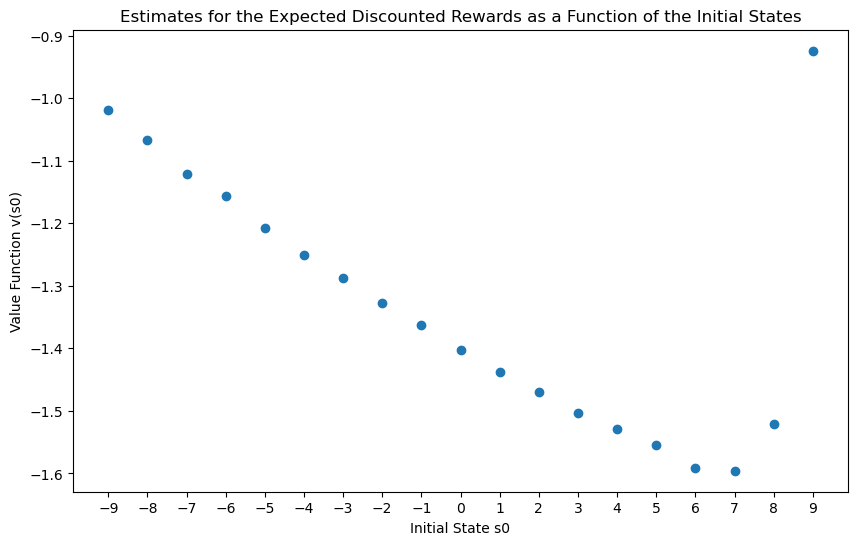

In [35]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either end of the path (-9 or 9), the episode ends and the robot doesn't make any more moves. Therefore, the top left and bottom right corner of the matrix both equal 1, as these represent the robot's current state being the leftmost or rightmost space in the path.

For every other space, the robot has an 80% chance of moving left, and a 20% chance of moving right.

In [36]:
P = np.zeros((19, 19))
P = pd.DataFrame(P)

for s in list(range(19)):
    if s == 0: # if robot is at the leftmost space
        P.iloc[s, s] = 1.0 # robot does not move
    elif s == 18: # if robot is at the rightmost space
        P.iloc[s, s] = 1.0 # robot does not move
    else: # if robot is anywhere else
        P.iloc[s, s+1] = 0.2 # 20% chance of moving right
        P.iloc[s, s-1] = 0.8 # 80% chance of moving left as intended
        
P.columns = list(range(-9, 10))
P.index = list(range(-9, 10))
P

,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9
-9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-5,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Question 3 -- 50/50 Left vs Right

#### Write a policy -- go right 50% of the time, left 50% of the time

Same as in Question 2, keep the "policy" itself as is but change the episode probabilities to reflect the 50/50 change.

In [37]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [38]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

In [39]:
env = Segment(numActions=2,startObservation=10,p=0.5,terminal=10,done=False) # change p = 0.5
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [40]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [41]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,1.0,0.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,0.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,-1.0,-2.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,-2.0,-1.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,-1.0,0.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,0.0,1.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,1.0,2.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,2.0,3.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,3.0,4.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [42]:
v0 = np.sum(dta['beta^t_reward'])
v0

-1.5895757997822069

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [43]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.5,terminal=10,done=False) # change p = 0.5
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [44]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,-1.0,0.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,0.0,1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,1.0,0.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,0.0,-1.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
44995,999.0,45.0,3.0,4.0,1.0,-0.05,0.98,0.402878,-0.020144
44996,999.0,46.0,4.0,5.0,1.0,-0.05,0.98,0.394820,-0.019741
44997,999.0,47.0,5.0,4.0,1.0,-0.05,0.98,0.386924,-0.019346
44998,999.0,48.0,4.0,3.0,1.0,-0.05,0.98,0.379185,-0.018959


#### Group by episode to sum the discounted realized rewards for each episode

In [45]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,-1.589576
1.0,-1.589576
2.0,-1.589576
3.0,-1.589576
4.0,-1.589576
...,...
995.0,-1.589576
996.0,-1.031786
997.0,-1.145766


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [46]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,-1.460490
std,0.392753
min,-1.942597
1%,-1.919614
5%,-1.760388
10%,-1.594803
25%,-1.589576
50%,-1.589576
75%,-1.589576


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

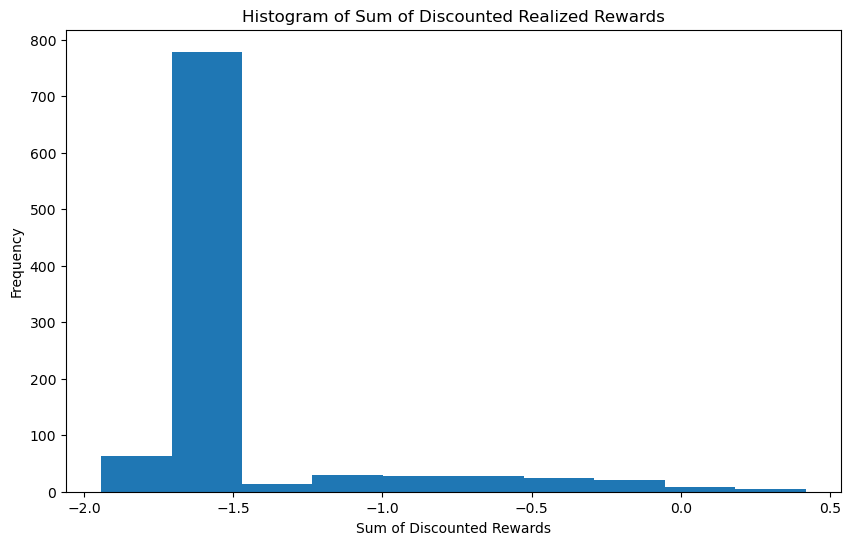

In [47]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [48]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.5,terminal=10,done=False) # change p = 0.5
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [49]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
1,-9.0,1.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
2,-9.0,1.0,1.0,-8.0,-9.0,1.0,-0.05,0.98,0.980000,-0.049000
3,-9.0,1.0,2.0,-9.0,-8.0,1.0,-0.05,0.98,0.960400,-0.048020
4,-9.0,1.0,3.0,-8.0,-7.0,1.0,-0.05,0.98,0.941192,-0.047060
...,...,...,...,...,...,...,...,...,...,...
622110,9.0,999.0,20.0,7.0,6.0,1.0,-0.05,0.98,0.667608,-0.033380
622111,9.0,999.0,21.0,6.0,7.0,1.0,-0.05,0.98,0.654256,-0.032713
622112,9.0,999.0,22.0,7.0,8.0,1.0,-0.05,0.98,0.641171,-0.032059
622113,9.0,999.0,23.0,8.0,9.0,1.0,-0.05,0.98,0.628347,-0.031417


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [50]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-1.1609,0.2380,-1.9312,-1.8314,-1.5896,-1.5896,-1.2239,-1.0594,-1.0000,-1.0000,-1.0000,-1.0000,-0.8757
-8.0,1000.0,-1.2891,0.2570,-1.9426,-1.8957,-1.6981,-1.5896,-1.5896,-1.1978,-1.0300,-1.0300,-1.0300,-1.0300,-0.8426
-7.0,1000.0,-1.3962,0.2385,-1.9312,-1.8579,-1.7142,-1.5896,-1.5896,-1.4573,-1.1712,-1.0594,-1.0594,-1.0006,-0.5121
-6.0,1000.0,-1.4584,0.2357,-1.9426,-1.9196,-1.8178,-1.6981,-1.5896,-1.5896,-1.2494,-1.1441,-1.0882,-0.9076,-0.3008
-5.0,1000.0,-1.5215,0.2000,-1.9312,-1.9078,-1.8314,-1.6850,-1.5896,-1.5896,-1.4573,-1.2239,-1.1164,-0.8757,-0.4301
-4.0,1000.0,-1.5303,0.2300,-1.9426,-1.9198,-1.8448,-1.7604,-1.5896,-1.5896,-1.5186,-1.2494,-1.1441,-0.6290,-0.3008
-3.0,1000.0,-1.5250,0.2645,-1.9312,-1.9312,-1.8053,-1.7142,-1.5896,-1.5896,-1.5896,-1.2239,-0.9400,-0.4293,0.0333
-2.0,1000.0,-1.5218,0.2899,-1.9426,-1.9196,-1.8448,-1.6981,-1.5896,-1.5896,-1.5896,-1.2989,-0.8426,-0.3879,0.3026
-1.0,1000.0,-1.4872,0.3466,-1.9312,-1.9080,-1.8039,-1.6480,-1.5896,-1.5896,-1.5896,-1.0612,-0.6664,0.0333,0.2465


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

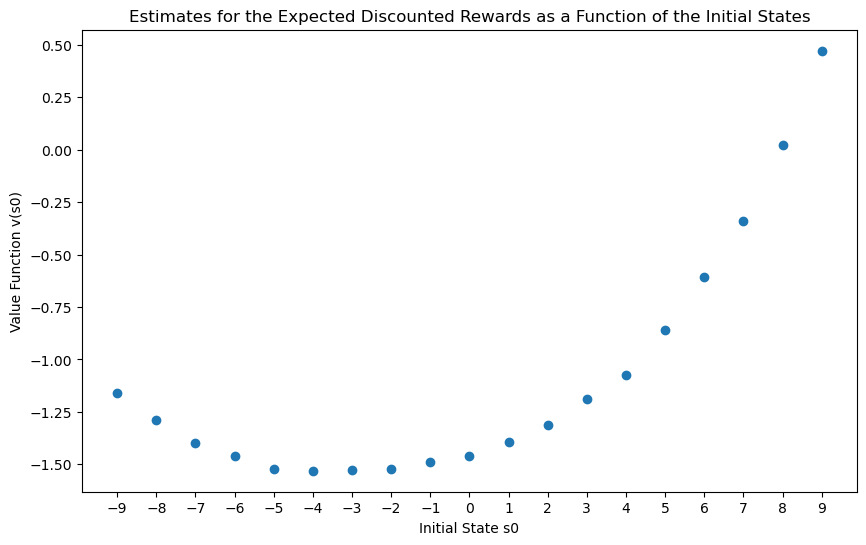

In [52]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either end of the path (-9 or 9), the episode ends and the robot doesn't make any more moves. Therefore, the top left and bottom right corner of the matrix both equal 1, as these represent the robot's current state being the leftmost or rightmost space in the path.

For every other space, the robot has a 50% chance of moving right, and a 50% chance of moving left.

In [53]:
P = np.zeros((19, 19))
P = pd.DataFrame(P)

for s in list(range(19)):
    if s == 0: # if robot is at the leftmost space
        P.iloc[s, s] = 1.0 # robot does not move
    elif s == 18: # if robot is at the rightmost space
        P.iloc[s, s] = 1.0 # robot does not move
    else: # if robot is anywhere else
        P.iloc[s, s+1] = 0.5 # 50% chance of moving right
        P.iloc[s, s-1] = 0.5 # 50% chance of moving left
        
P.columns = list(range(-9, 10))
P.index = list(range(-9, 10))
P

,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9
-9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-5,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
